I'll be showing how the HSAR userclass works and comparing the results from OLS and the HSAR in estimating effects for the example data provided.

In [57]:
import hlm
import pysal as ps
import pandas as pd
import numpy as np

In [58]:
data = pd.read_csv('./test.csv')

In [59]:
data.head()

,id,u.full,y,x,county
0,0,-0.689048,0.788457,1,1
1,1,-0.689048,0.788457,0,1
2,2,-0.689048,1.064711,0,1
3,3,-0.689048,0.000000,0,1
4,4,-0.847313,1.131402,0,2


In [60]:
y = data[['y']].values
X = data[['x']].values

In [61]:
W = ps.open('./w_lower.mtx').read()
M = ps.open('./w_upper.mtx').read()
W.transform = M.transform = 'r'

In [62]:
membership = data[['county']].values - 1

In [63]:
ols = ps.spreg.OLS(y,X,W)

In [64]:
pd.DataFrame(np.hstack((ols.betas, ols.std_err.reshape(ols.betas.shape))),
             columns=['$\\beta$', '$\sigma_\\beta$'])

,$\beta$,$\sigma_\beta$
0,1.326744,0.029721
1,-0.613395,0.072841


Thus, if we just estimate these naively via ols, this is what we get

### The Dong Harris HSAR

The user class will take 1000 samples if you don't pass a `cycles` argument. So, just to show how the user class works, I'll set it up but not start the sampler.

In [65]:
dh = hlm.HSAR(y,X,W,M,membership=membership, n_samples=0)
#dh._verbose = 1
#dh.samplers[-1]._propose = dh.samplers[-1]._trunc_propose
#dh.samplers[-2]._propose = dh.samplers[-2]._trunc_propose

The public methods and attributes in the sampler are:

In [66]:
[x for x in dir(dh) if not x.startswith('_')]

['M',
 'W',
 'add_steps',
 'cycles',
 'front',
 'hypers',
 'sample',
 'samplers',
 'steps',
 'trace',
 'var_names']

a short summary from the full specification document in `hlm/spec.md`:

parameter set: 
- `front` : front sample of parameters
- `current`: current sample of parameters
- `previous`: previous sample of parameters

movement:
- `cycle`: compute one sample, either full or partial
- `step`: take one draw from the sampler and increment the position by 1
- `sample`: take an arbitrary number of cycles or steps

indexing:
- `position`: current position within a full cycle
- `cycles`: number of full perfect samples drawn
- `steps`: number of times that the position has been incremented

data & configuration:
- `hypers` : namespace containing hyperparameters used for model
- `samplers`: list of samplers being used 
- `trace`: collection of previous samples
- `var_names` : names of the samplers

In [67]:
dh.sample(cycles=1000)

In [68]:
np.vstack(dh.trace.Betas).mean(axis=0)

array([ 1.23340603, -0.61083825])

And so we get a slightly larger constant and an effect that's quite close. The standard errors are:

In [69]:
np.sqrt(np.vstack(dh.trace.Betas).var(axis=0))

array([ 0.29768817,  0.07590367])

Much larger for the constant, but about the same for the estimated effect. 

Now, where this gets nice is that we can make plots of the posterior predictive distributions. We could do this with OLS, too, since each $\hat{\beta} \sim \mathcal{N}(\beta, SE_\hat{\beta})$, but...

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

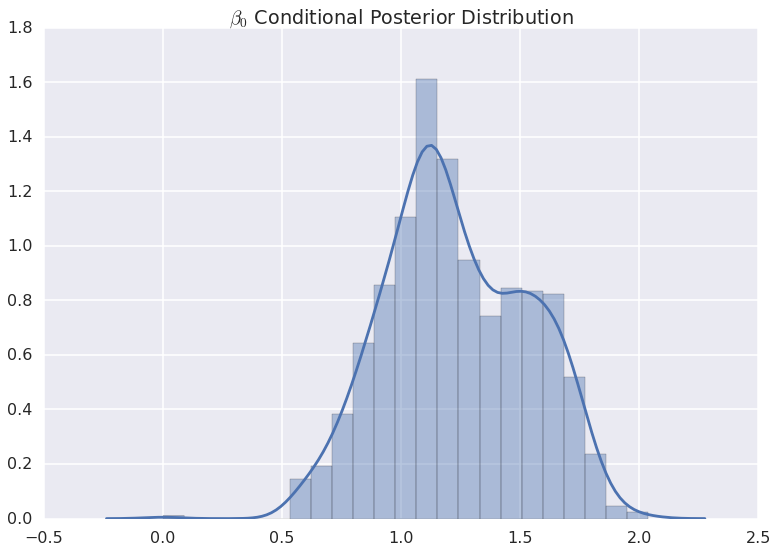

In [71]:
sns.distplot(np.vstack(dh.trace.Betas).T[0])
plt.title('$\\beta_0$ Conditional Posterior Distribution')

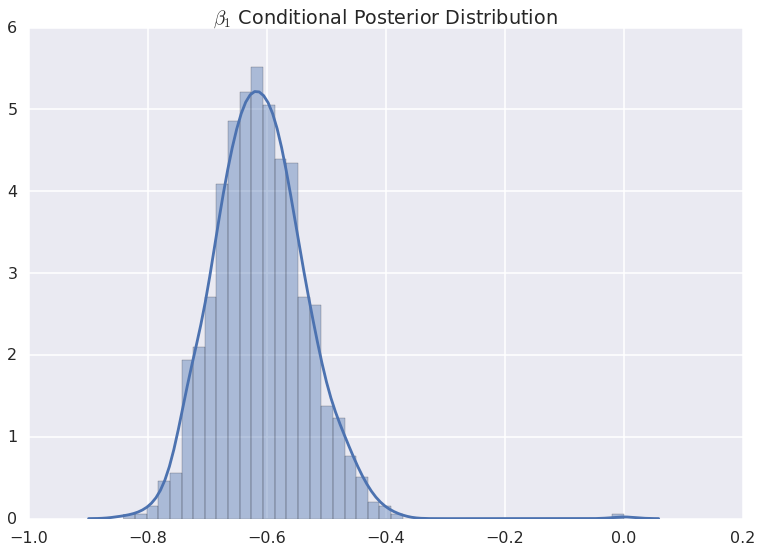

In [72]:
sns.distplot(np.vstack(dh.trace.Betas).T[1])
plt.title('$\\beta_1$ Conditional Posterior Distribution')

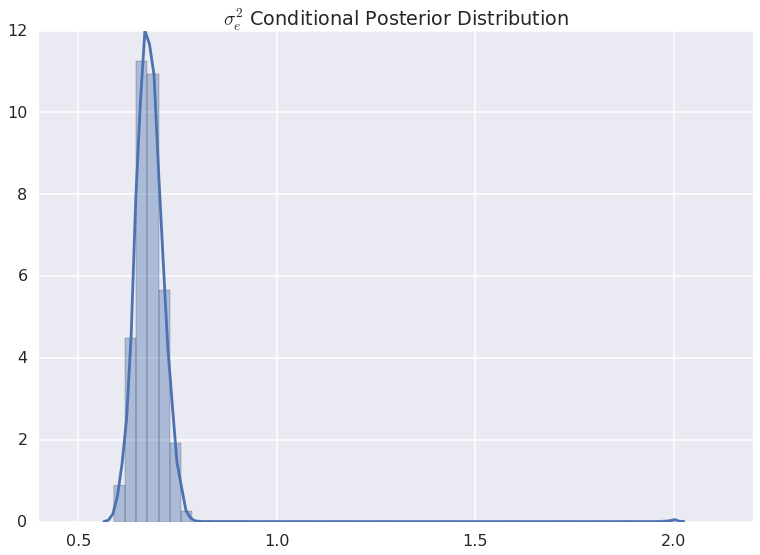

In [73]:
sns.distplot(np.vstack(dh.trace.Sigma2_e))
plt.title('$\\sigma_e^2$ Conditional Posterior Distribution')

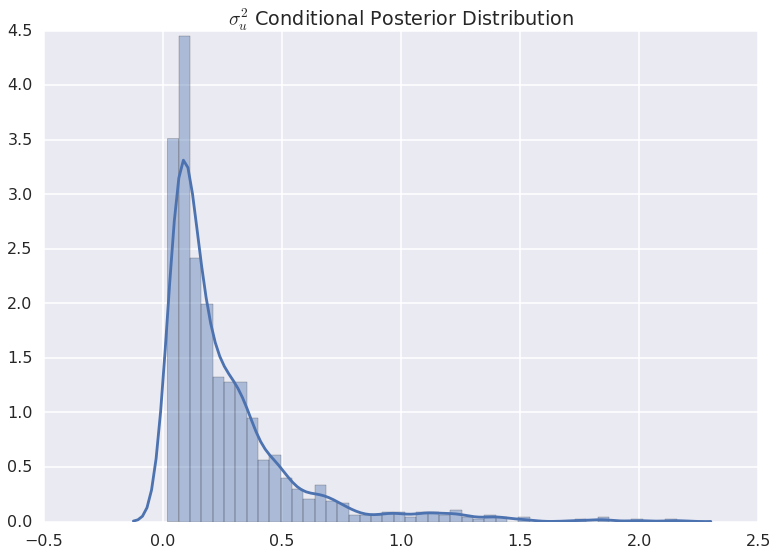

In [74]:
sns.distplot(np.vstack(dh.trace.Sigma2_u))
plt.title('$\\sigma_u^2$ Conditional Posterior Distribution')

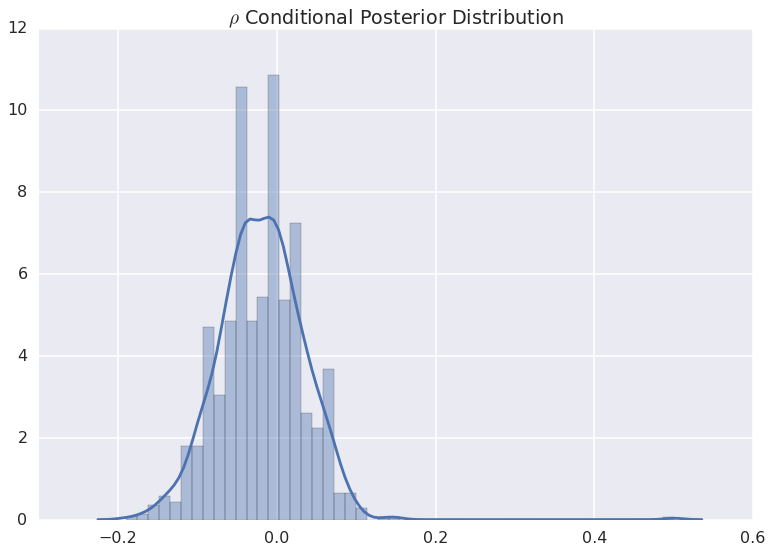

In [75]:
sns.distplot(np.vstack(dh.trace.Rho))
plt.title('$\\rho$ Conditional Posterior Distribution')

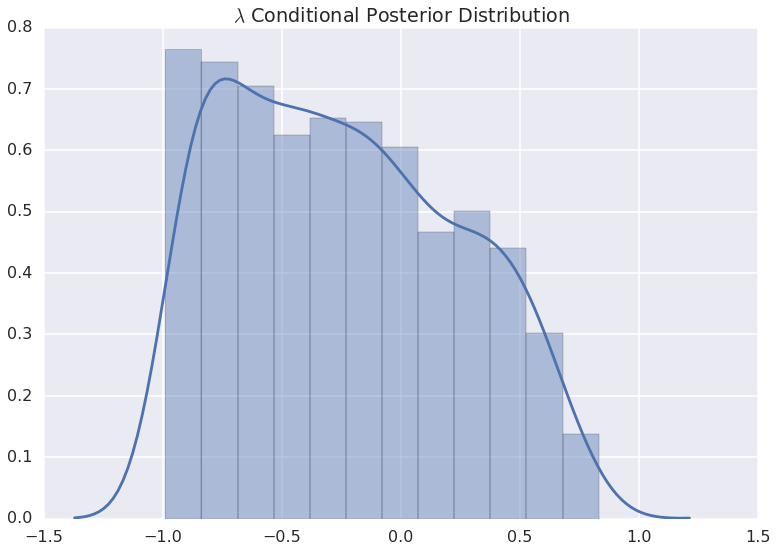

In [76]:
sns.distplot(np.vstack(dh.trace.Lambda))
plt.title('$\lambda$ Conditional Posterior Distribution')

In [85]:
dhchol = hlm.HSAR(y,X,W,M,membership=membership, 
                  effect_method='chol', n_samples=0)

In [86]:
dhchol.sample(1000)

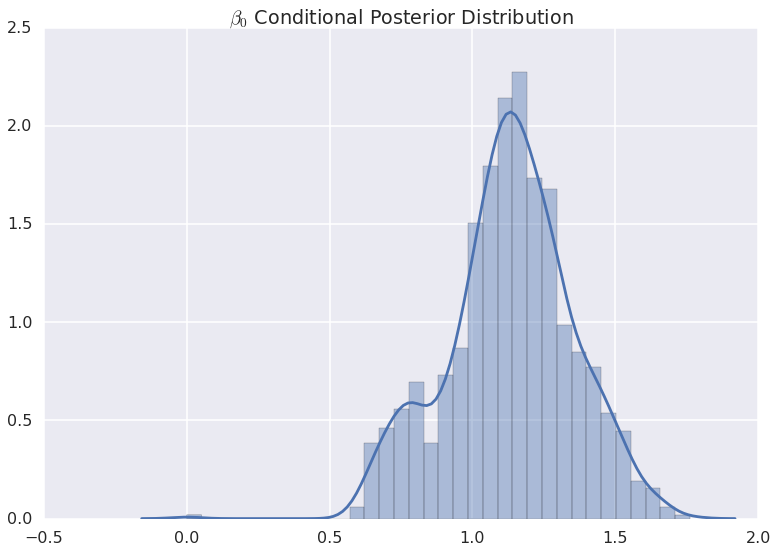

In [87]:
sns.distplot(np.vstack(dhchol.trace.Betas).T[0])
plt.title('$\\beta_0$ Conditional Posterior Distribution')

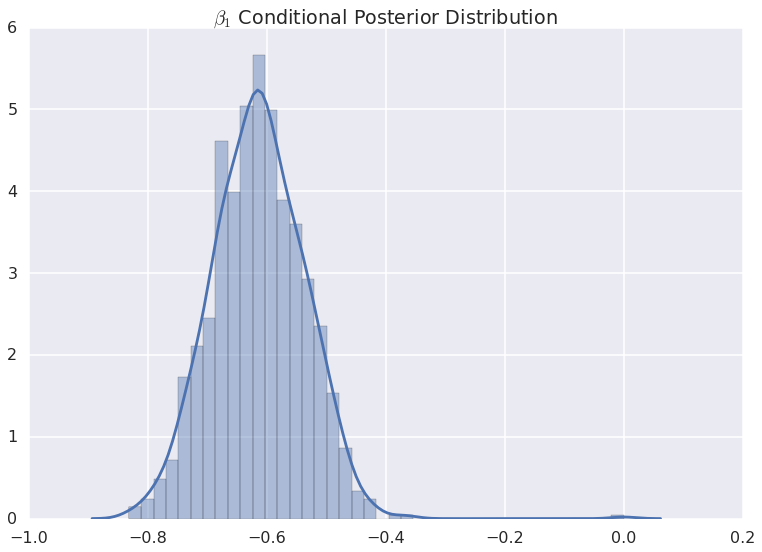

In [88]:
sns.distplot(np.vstack(dhchol.trace.Betas).T[1])
plt.title('$\\beta_1$ Conditional Posterior Distribution')

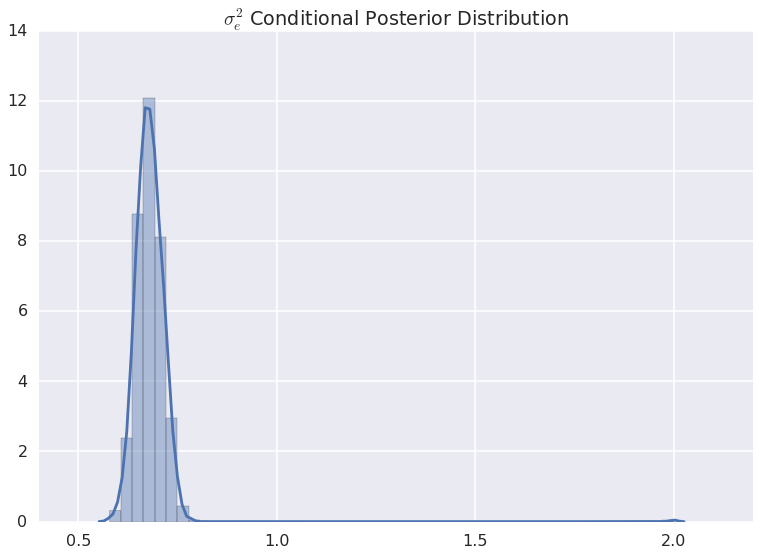

In [89]:
sns.distplot(np.vstack(dhchol.trace.Sigma2_e))
plt.title('$\\sigma_e^2$ Conditional Posterior Distribution')

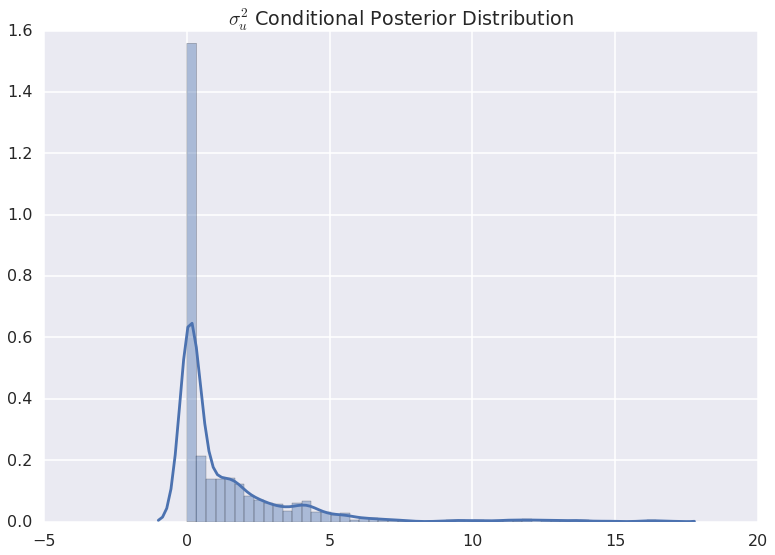

In [90]:
sns.distplot(np.vstack(dhchol.trace.Sigma2_u))
plt.title('$\\sigma_u^2$ Conditional Posterior Distribution')

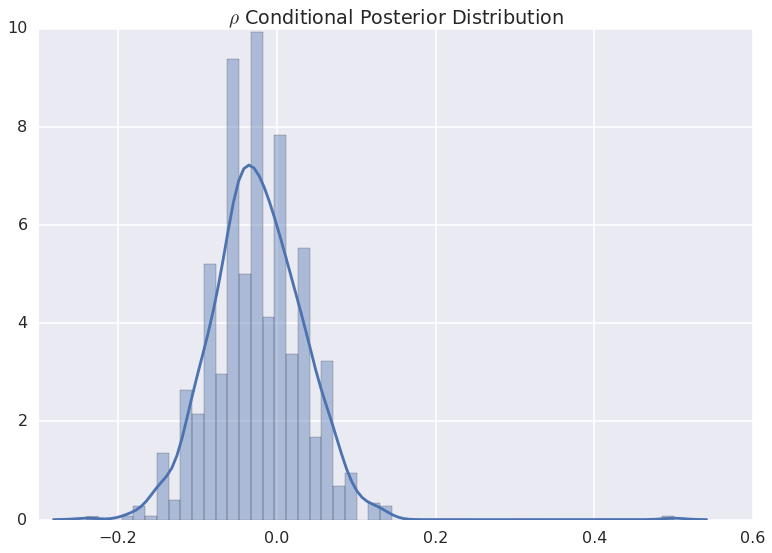

In [91]:
sns.distplot(np.vstack(dhchol.trace.Rho))
plt.title('$\\rho$ Conditional Posterior Distribution')

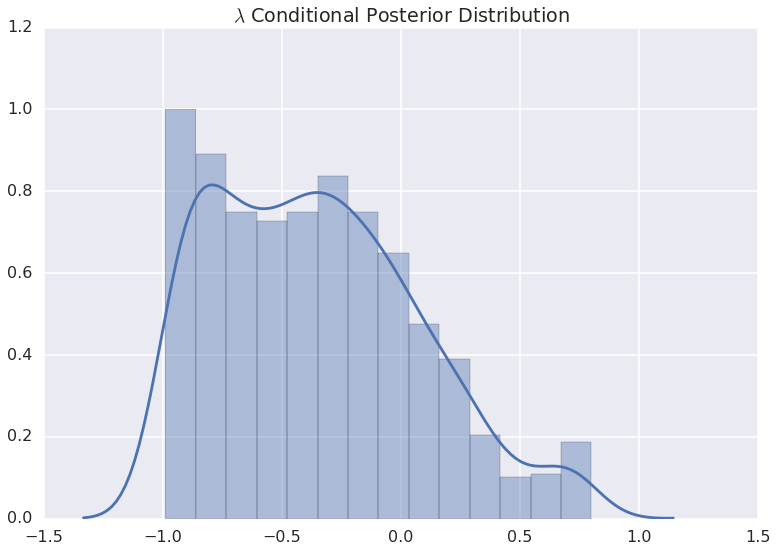

In [92]:
sns.distplot(np.vstack(dhchol.trace.Lambda))
plt.title('$\\lambda$ Conditional Posterior Distribution')

In [95]:
dh_met = hlm.HSAR(y,X,W,M,membership=membership, 
                  effect_method='chol', 
                  spatial_method='metropolis', 
                  n_samples=0)
dh_met.sample(1000)

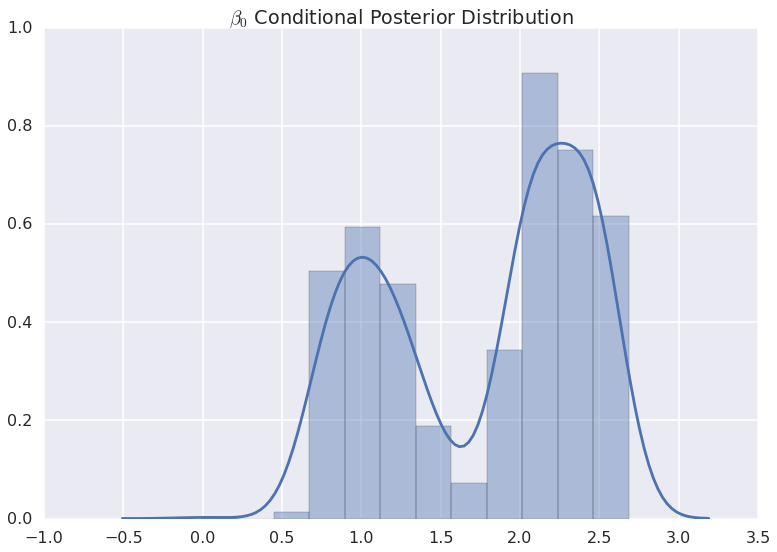

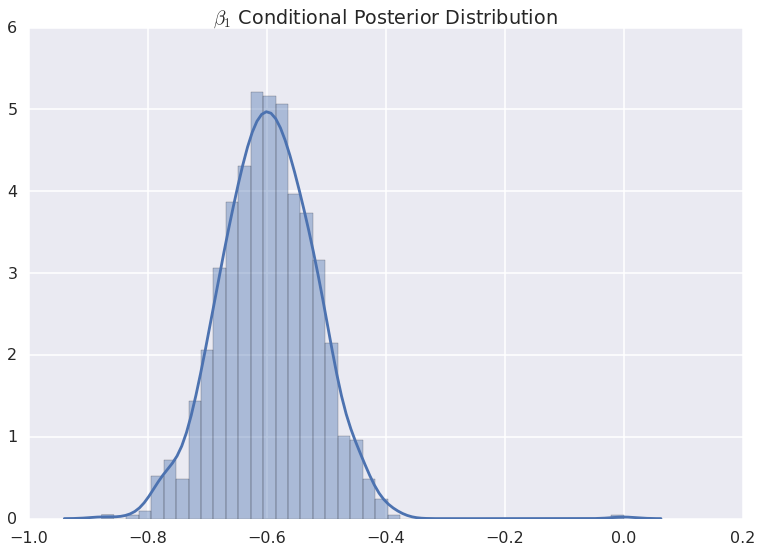

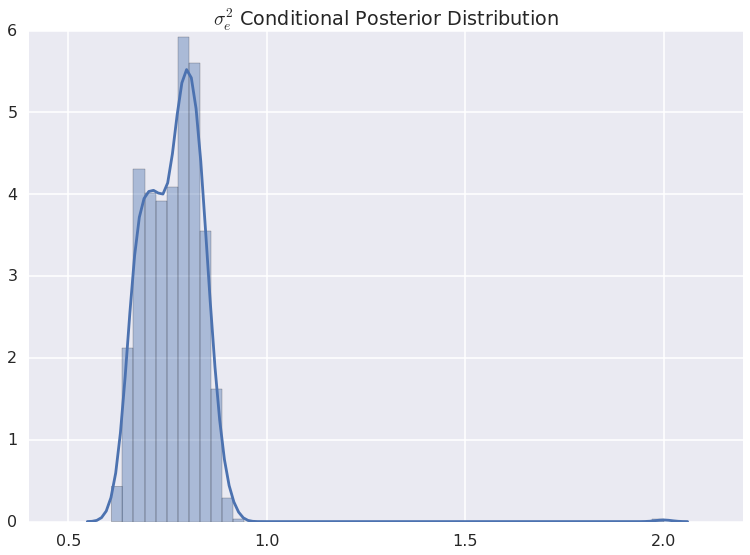

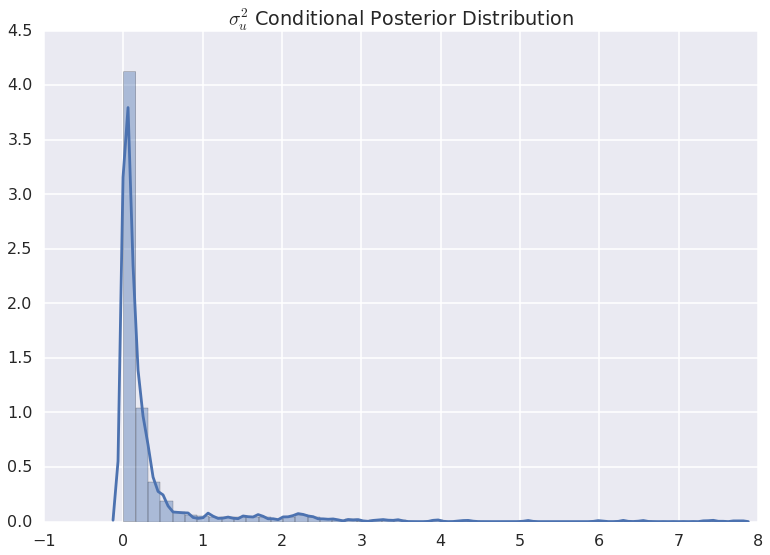

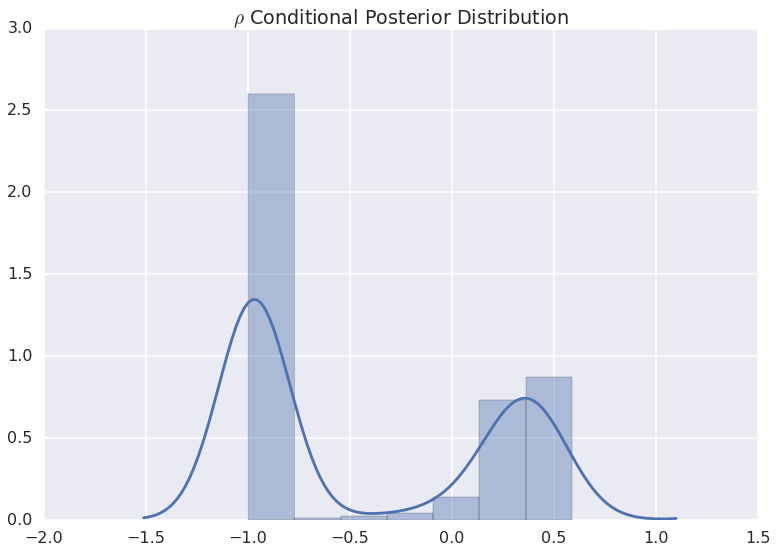

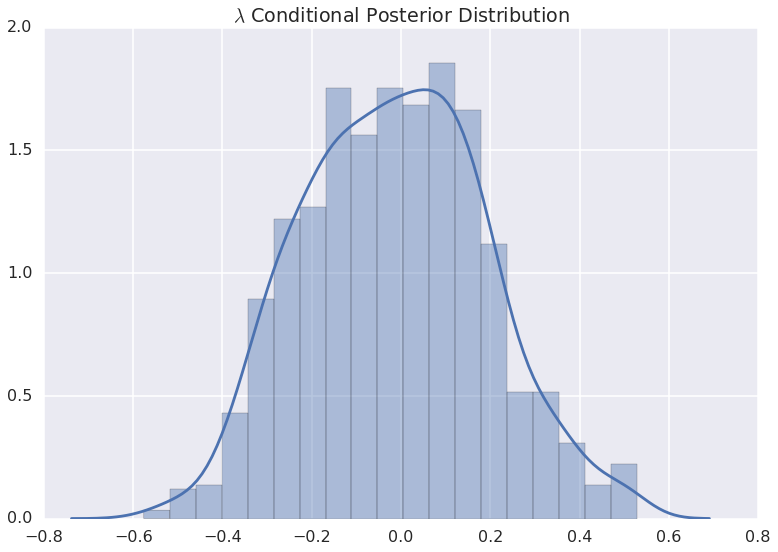

In [110]:
sns.distplot(np.vstack(dh_met.trace.Betas).T[0])
plt.title('$\\beta_0$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Betas).T[1])
plt.title('$\\beta_1$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Sigma2_e))
plt.title('$\\sigma_e^2$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Sigma2_u))
plt.title('$\\sigma_u^2$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Rho))
plt.title('$\\rho$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Lambda))
plt.title('$\\lambda$ Conditional Posterior Distribution')
plt.show()

In [112]:
dh_met = hlm.HSAR(y,X,W,M,membership=membership, 
                  effect_method='chol', 
                  spatial_method='metropolis', 
                  n_samples=0)
dh_met.samplers[-1]._propose = dh_met.samplers[-1]._trunc_propose 
dh_met.samplers[-2]._propose = dh_met.samplers[-2]._trunc_propose 
dh_met.sample(1000)

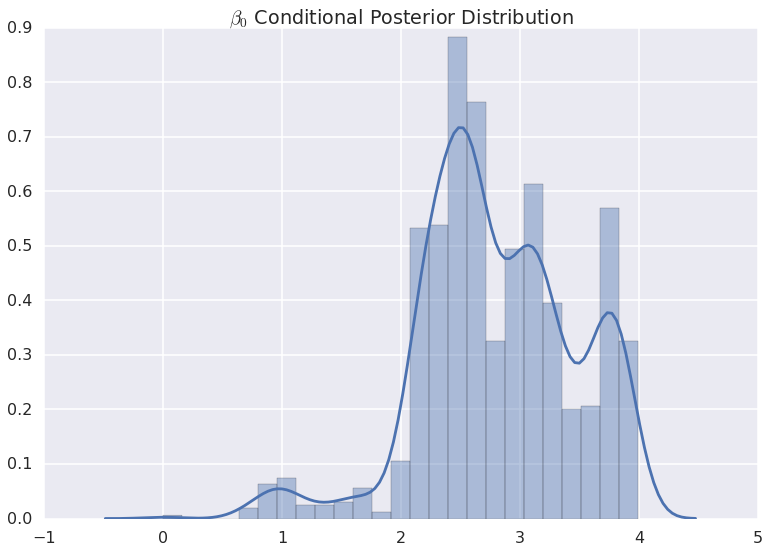

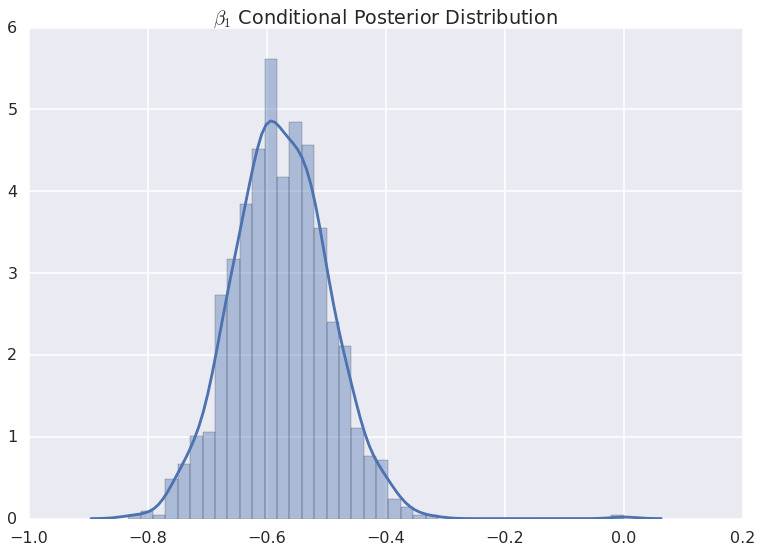

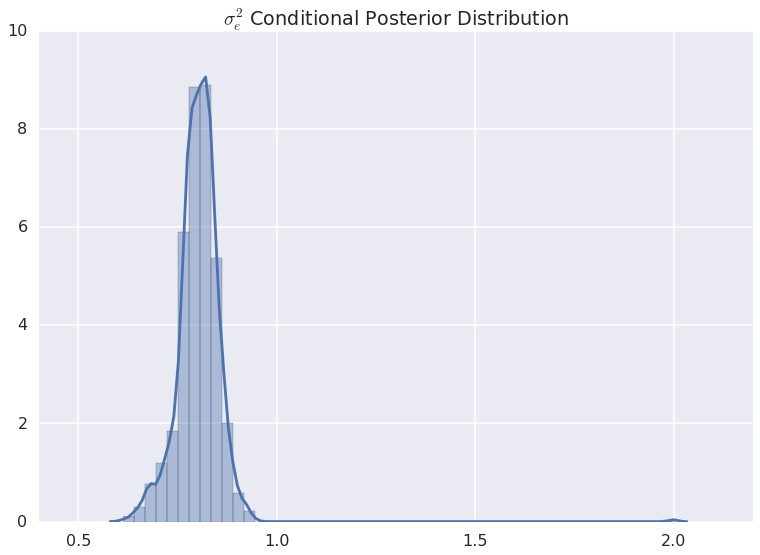

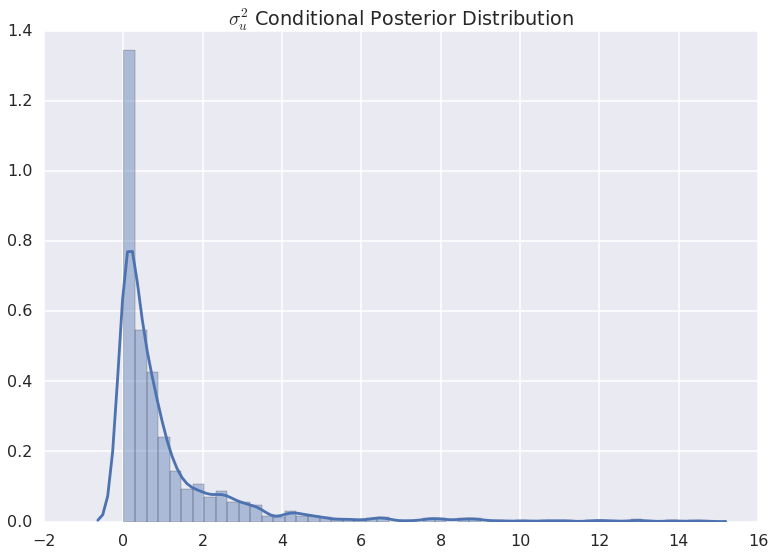

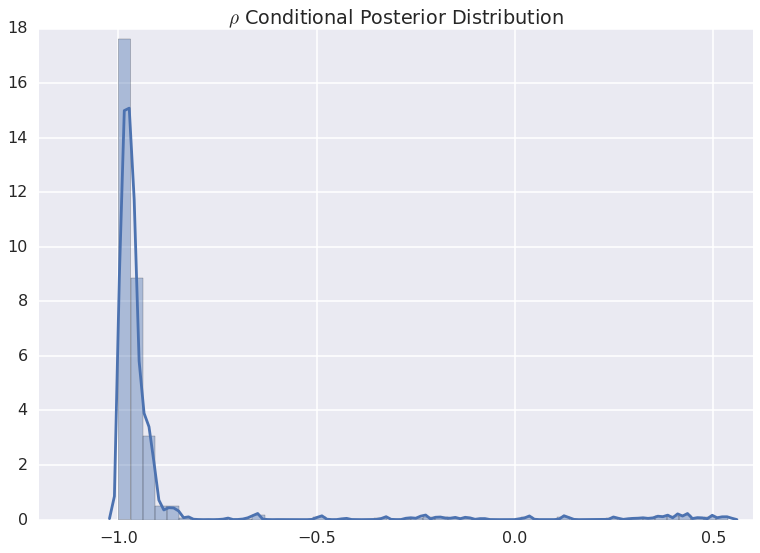

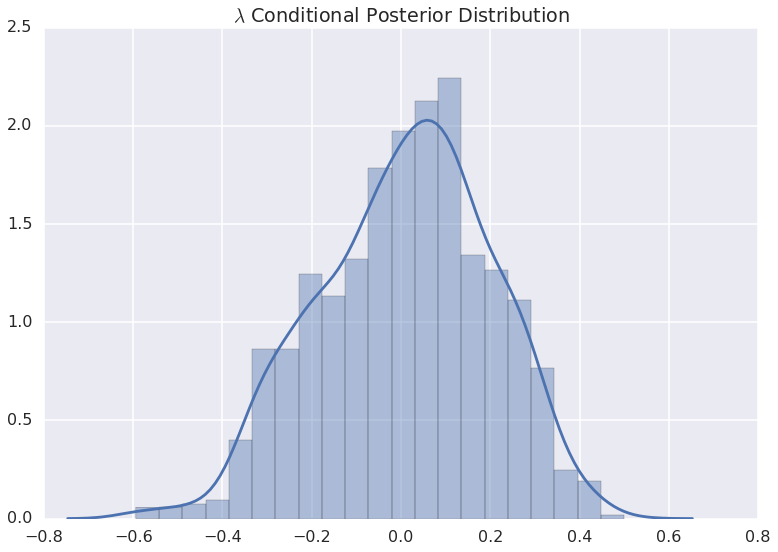

In [113]:
sns.distplot(np.vstack(dh_met.trace.Betas).T[0])
plt.title('$\\beta_0$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Betas).T[1])
plt.title('$\\beta_1$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Sigma2_e))
plt.title('$\\sigma_e^2$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Sigma2_u))
plt.title('$\\sigma_u^2$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Rho))
plt.title('$\\rho$ Conditional Posterior Distribution')
plt.show()
sns.distplot(np.vstack(dh_met.trace.Lambda))
plt.title('$\\lambda$ Conditional Posterior Distribution')
plt.show()